In [1]:
from metro_utils import (graph, extract_stations, pairs2rails, subsets, 
                         total_distance, gen_distance_matrix, graph_x)
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} w_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} w_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} w_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} w_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&w_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [2]:
# Load test cases
# Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html 
# for creating these easily

from json import load

ignore_fields = ["description", "comment", "source"]
def filter_ignore(d):
    return {k: v for k, v in d.items() if k not in ignore_fields}

with open("test_cases.json", "r") as f:
    tests = load(f, object_hook=filter_ignore)

In [25]:
# Choose problem to use in code below
test_choice = "3_cluster"
locations = tests[test_choice]["locations"]
kinds = tests[test_choice]["kinds"]

city = City(**tests[test_choice])
stations = city.stations

In [26]:
def tsp(city, verbose=True):
    
    n_stations = len(city.stations)
    
    dist = gen_distance_matrix(city)
    
    S = list(range(n_stations))
    subs = subsets(S)
    
    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
    
    w = m.addVars(n_stations, n_stations, vtype=GRB.INTEGER, name="x")

    m.setObjective(gp.quicksum(dist[s1, s2]*w[s1, s2] for s1 in S for s2 in S if s1 != s2), GRB.MINIMIZE)

    # leave each station only once
    m.addConstrs(gp.quicksum(w[s1, s2] for s1 in S if s1 != s2 ) == 1 for s2 in S)
    # enter each station only once
    m.addConstrs(gp.quicksum(w[s1, s2] for s2 in S if s1 != s2 ) == 1 for s1 in S)
    # Subtour elimination constraints
    for sub in subs:
        m.addConstr(gp.quicksum(w[s1, s2] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1)

    m.optimize()
    
    return m
    
m = tsp(city)
best = pairs2rails([extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6])
graph(stations, best, equal_aspect=True, filename='tsp_'+test_choice, show_station_ids=False)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2521 rows, 144 columns and 51216 nonzeros
Model fingerprint: 0xdcf0d2bb
Variable types: 0 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 16.3742472
Presolve removed 0 rows and 12 columns
Presolve time: 0.05s
Presolved: 2521 rows, 132 columns, 51216 nonzeros
Variable types: 0 continuous, 132 integer (132 binary)

Root relaxation: objective 5.599685e+00, 36 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.5996849    5.59968  0.00%     -    0s

Explored 1 nodes (36 simplex itera

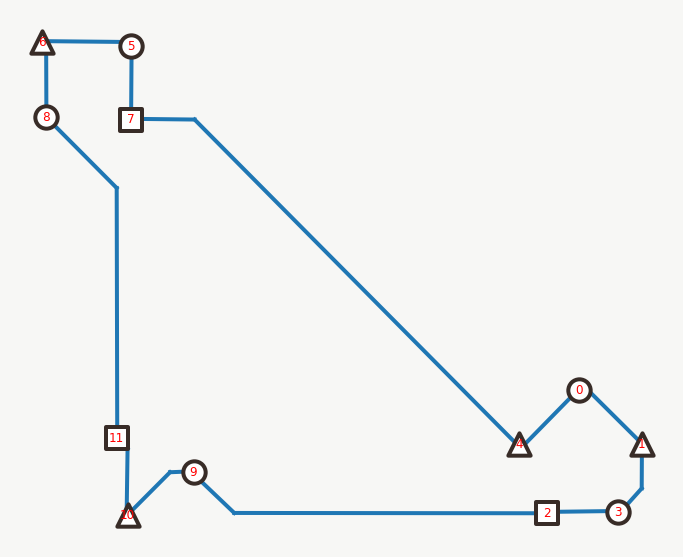

In [27]:
graph(stations, best, equal_aspect=True, show_station_ids=True)

## Stage 1 - Ants (with Ghost Depot)

In [28]:
import gurobipy as gp
from gurobipy import GRB

def ants(city, verbose=True):
    n_stations = len(city.stations)
    S = list(range(n_stations))
    dist = gen_distance_matrix(city)
    subs = subsets(S)
    
    DUMMY = n_stations
    M = 3
    D = range(M)
    S0 = S + [DUMMY]
    K = 1#3
    L = 100#N_STATIONS - (M-1)*K
    mk = 1 # Num trains from kth depot

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)

    w = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.BINARY, name="w")
    u = m.addVars(n_stations, vtype=GRB.INTEGER, name="u")

    # 1
    m.setObjective(gp.quicksum(dist[i, j]*w[i, j, k] for k in D for j in S for i in S), GRB.MINIMIZE)

    # 2
    m.addConstrs(gp.quicksum(w[DUMMY, j, k] for j in S) == mk for k in D)
    # 3
    m.addConstrs(gp.quicksum(w[i, j, k] for i in S0 for k in D) == 1 for j in S)
    # 4
    m.addConstrs(gp.quicksum(w[i, j, k] for i in S0) - gp.quicksum(w[j, i, k] for i in S0) == 0
                 for k in D for j in S)
    # 5
    m.addConstrs(gp.quicksum(w[DUMMY, j, k] for j in S) - gp.quicksum(w[j, DUMMY, k] for j in S) == 0 for k in D)
    # 6
    m.addConstrs(u[i] + (L - 2)*gp.quicksum(w[DUMMY, i, k] for k in D) - 
                 gp.quicksum(w[i, DUMMY, k] for k in D) <= L - 1 for i in S)
    # 7
    m.addConstrs(u[i] + gp.quicksum(w[DUMMY, i, k] for k in D) + (2 - K)*gp.quicksum(w[i, DUMMY, k] for k in D) >= 2 for i in S)
    # 8
    m.addConstrs(gp.quicksum(w[DUMMY, i, k] for k in D) + gp.quicksum(w[i, DUMMY, k] for k in D) <= 1 for i in S)
    # 9
    m.addConstrs(u[i] - u[j] + L*gp.quicksum(w[i, j, k] for k in D) + 
                 (L - 2)*gp.quicksum(w[j, i, k] for k in D) <= L - 1 for i in S for j in S if i != j)
    # 10
    m.addConstrs(w[i, i, k] == 0 for i in S for k in D)

    m.optimize()
    return m

m = ants(city, verbose=False)

In [29]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'w' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
#display(connections)

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])

In [30]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))

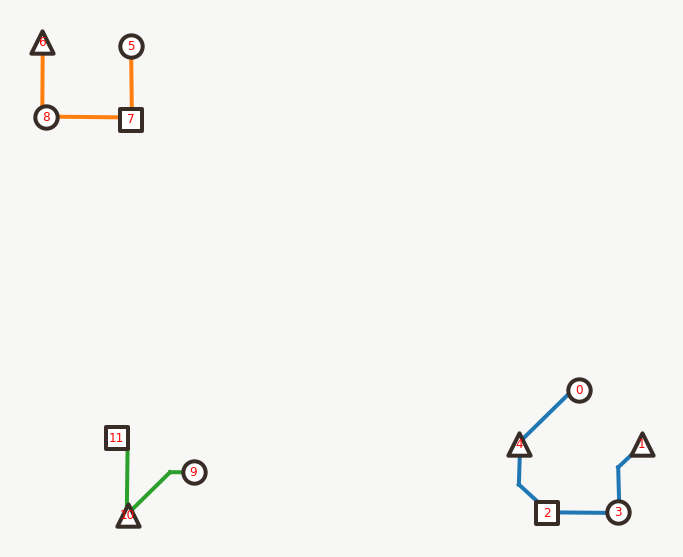

In [31]:
graph(stations, rails, equal_aspect=True, show_station_ids=False, filename='ants_'+test_choice)
graph(stations, rails, equal_aspect=True, show_station_ids=True)

## Stage 2 - MIP Approach

## SDVRP - Based Implementation

In [32]:
def choose_flow_root(city, debug=False):
    """Returns id of most central station for flow root"""
    positions = np.array(list(map(lambda s: [s.x, s.y], city.stations)))
    mean = positions.sum(0) / len(city.stations)
    if debug: print("Mean: ", mean)
    
    best_s, best_dist = None, 10e5
    for s in city.stations:
        dist = np.linalg.norm(mean - np.array([s.x, s.y]))
        if debug: print((s, s.x, s.y, dist))
        if dist < best_dist:
            best_s, best_dist = s, dist
    
    return best_s.id

In [33]:
def sdvrp(city, verbose=True):
    
    # A few modifications, but otherwise the same hyperparameters
    n = n_stations = len(city.stations)  # no. customers
    M = 3  # no. rails
    D = range(M) # set of vehicles
    S = list(range(n_stations))  # customers
    DUMMY = n  # dummy depot's index
    S0 = S + [DUMMY]  # customers + depot

    d = [1]*n # Customer demands, set to unit
    Q = n  # capacities of vehicles (assumed homogenous)
    K = 1 # min number of visited stations (excluding depot)
    mk = 1 # Num trains from kth depot
    dist = gen_distance_matrix(city)   # cost matrix
    INF = 10e7

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
        
    K = 1  # relevant to an extra constraint that avoids short-lived train stops; Ants approach would do better here

    w = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.BINARY, name="w") # node i --> node j on path of vehicle k
    y = m.addVars(n_stations, M, lb=0.0, name="y")  # quantity of ith site's demand satisfied by kth vehicle/route
    u = m.addVars(n_stations, M, lb=0.0, name="u")  # MTZ potentials
    p = m.addVars(n_stations, n_stations, lb=0.0, name="p") # Whole-network flow potentials
    e = m.addVars(n_stations, n_stations, vtype=GRB.BINARY, name="e") # indicators for edge use

    m.setObjective(gp.quicksum(dist[i,j]*w[i,j,k] for i in S for j in S for k in D), GRB.MINIMIZE)
    
    ### FLOW CONSTRAINTS FOR A FC GRAPH
    FLOW_ROOT = choose_flow_root(city)
    # A flow of 1 must exit the 'root'
    m.addConstr(gp.quicksum(p[FLOW_ROOT,j] for j in S if j != FLOW_ROOT) == 1) 
    # cannot have self-flows
    m.addConstrs(p[i,i] <= 0 for i in S)
    # Outflow - Inflow = 1 for non-roots (i.e. all nodes increase flow by one)
    m.addConstrs(gp.quicksum(p[i,j] for j in S) - gp.quicksum(p[j,i] for j in S) == 1 for i in S if i != FLOW_ROOT)
    # Flow can only occur where an edge is formed
    m.addConstrs(p[i,j] <= (n_stations)*e[i,j] for i in S for j in S if i != j)
    # Flow into the root must be N for any edge going into it
    m.addConstrs(gp.quicksum(p[i, FLOW_ROOT] for i in S) == n_stations for i in S if i != FLOW_ROOT)
    # Edge-indicator setup
    m.addConstrs(e[i,j] <= 0.5 + gp.quicksum(w[i,j,k] for k in D) for i in S for j in S)
    m.addConstrs(e[i,j] >= gp.quicksum(w[i,j,k] for k in D) / INF for i in S for j in S)

    ### EDGE CONSISTENCY CONSTRAINTS
    # At least one edge enters every j (including the depot)
    m.addConstrs(gp.quicksum(w[i,j,k] for i in S0 for k in D) >= 1 for j in S0)
    # in == out for every node + depot, per-route basis (and hence in general)
    m.addConstrs((gp.quicksum(w[i,j,k] for i in S0) - gp.quicksum(w[j,i,k] for i in S0) == 0 for j in S0 for k in D))

    ### SUBTOUR CONSTRAINTS 
    # SEC using MTZ
    m.addConstrs((u[i,k] - u[j,k] + n_stations*w[i,j,k] <= n_stations-1 + \
                      n_stations*w[j,DUMMY,k] for i in S for j in S if i != j for k in D))

    ### DEMAND CONSTRANTS
    # ith demand can only be sated by route k if there's an outbound edge from i on that path
    m.addConstrs(y[i,k] <= d[i]*gp.quicksum(w[i,j,k] for j in S0) for i in S for k in D)
    # Total sated demand @ i must meet demand
    m.addConstrs(gp.quicksum(y[i,k] for k in D) == d[i] for i in S)
    # Total sated demand by k cannot exceed capacity of vehicle
    m.addConstrs((gp.quicksum(y[i,k] for i in S) <= Q for k in D))

    ### OTHER constraints
    # No self-joins
    m.addConstrs(w[i,i,k] <= 0 for i in S0 for k in D)
    # For a given k, you must (and only once) enter the dummy depot, and leave the dummy depot
    m.addConstrs(gp.quicksum(w[i,DUMMY,k] for i in S) == mk for k in D)
    m.addConstrs(gp.quicksum(w[DUMMY,i,k] for i in S) == mk for k in D)
    # Same vehicle cannot cross the same connection twice (excluding depot)
    m.addConstrs((w[i,j,k] + w[j,i,k] <= 1 for i in S for j in S for k in D))
    # Routes must have more than K edges (K >= 1)
    m.addConstrs((gp.quicksum(w[i,j,k] for i in S for j in S) >= K for k in D))

    m.optimize()
    
    return m
    
m = sdvrp(city)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1434 rows, 867 columns and 6787 nonzeros
Model fingerprint: 0x13ad470a
Variable types: 216 continuous, 651 integer (651 binary)
Coefficient statistics:
  Matrix range     [1e-08, 1e+01]
  Objective range  [2e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+01]
Presolve removed 458 rows and 63 columns
Presolve time: 0.01s
Presolved: 976 rows, 804 columns, 5304 nonzeros
Variable types: 204 continuous, 600 integer (600 binary)

Root relaxation: objective 2.532323e+00, 634 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.53232    0   50          -    2.53232      -     -    0s
     0     0    3.23038    0   72          -    3.23038      -     -    0s
H

In [34]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'w' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
#display(connections)

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])

In [35]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs, debug=False))

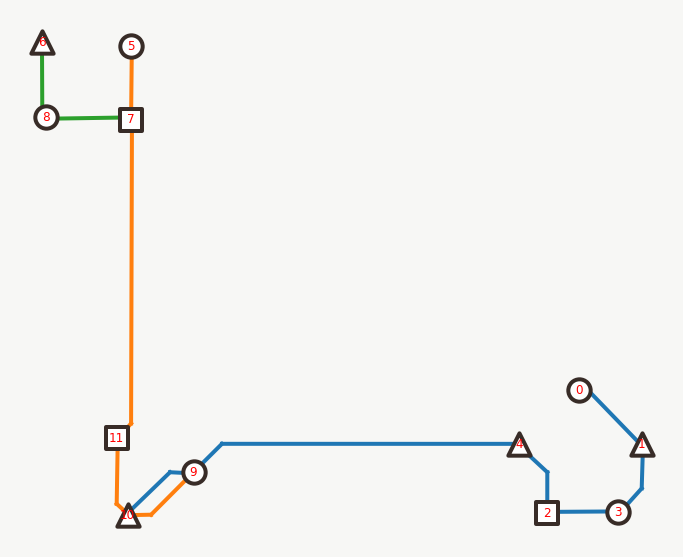

In [36]:
graph(stations, rails, jitter=True, equal_aspect=True, filename='sdvrp_'+test_choice, show_station_ids=False)
graph(stations, rails, jitter=True, equal_aspect=True)

### Random

- `hexagon` + biased demand weights == easy check that overlap is okay
- `loop_feasibility` + negative costs == easy check that loops are okay 
- `donut` == easy check for a problem that needs a loop solution

# Computational Studies

In [77]:
from time import time
from tqdm import tqdm

def experiment(n_stations_range, num_trials, formulation, verbose=True):
    
    # Store results
    res_n_stations = []
    res_time_taken = []
    
    iterator = tqdm(n_stations_range) if verbose else n_stations_range
    
    for n_stations in iterator:
        for _ in range(num_trials):
            
            t0 = time()
            formulation(City(n_stations), verbose=False)
            t1 = time()
            
            res_n_stations.append(n_stations)
            res_time_taken.append(t1 - t0)
            
    return res_n_stations, res_time_taken

In [78]:
tsp_n_stations, tsp_time_taken = experiment(range(2, 21), 5, tsp)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [20:36<00:00, 65.09s/it]


In [79]:
ants_n_stations, ants_time_taken = experiment(range(2, 27), 5, ants)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [11:51<00:00, 28.47s/it]


In [80]:
sdvrp_n_stations, sdvrp_time_taken = experiment(list(range(2, 30)) + [35, 40, 45, 50], 5, sdvrp)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [05:01<00:00,  9.43s/it]


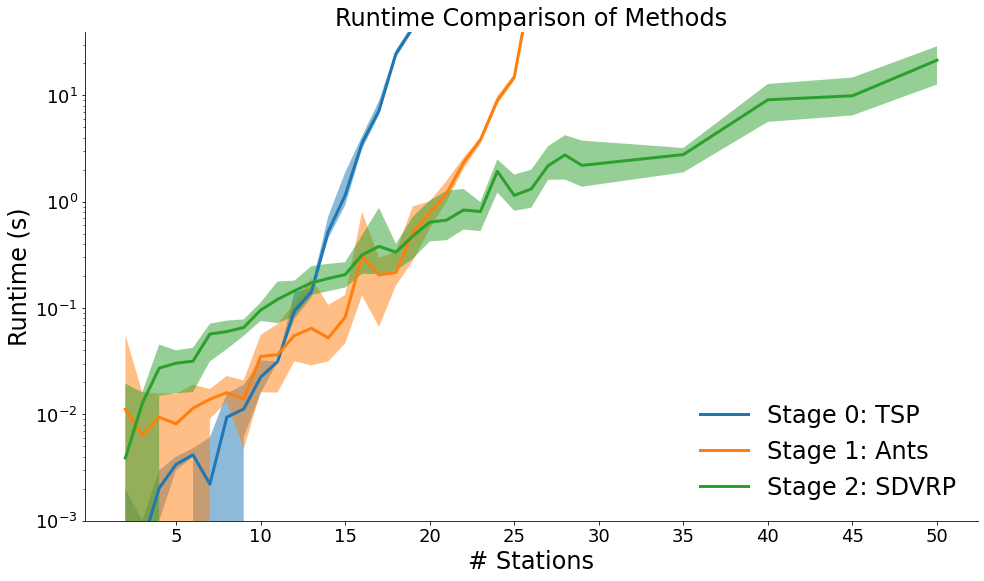

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

fig, ax = plt.subplots(figsize=(16, 9))

results = {'Stage 0: TSP':   (  tsp_n_stations,   tsp_time_taken), 
           'Stage 1: Ants':  ( ants_n_stations,  ants_time_taken),
           'Stage 2: SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

def get_sum_stats(x, y):
    vals = defaultdict(list)
    
    for x_, y_ in zip(x, y):
        vals[x_].append(y_)
        
    xs = []
    means = []
    sds = []
    mins = []
    maxs = []
    for x, ys in vals.items():
        ys = np.array(ys)
        xs.append(x)
        means.append(ys.mean())
        sds.append(ys.std())
        mins.append(ys.min())
        maxs.append(ys.max())
        
    return np.array(xs), np.array(means), np.array(sds), np.array(mins), np.array(maxs)

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

ax.set_yscale('log')
ax.set_ylim(1e-3, 10**1.6)

ax.legend(frameon=False)

sns.despine()

plt.savefig('log_runtimes4.png', facecolor='white', transparent=False, dpi=fig.dpi*2)

plt.show()

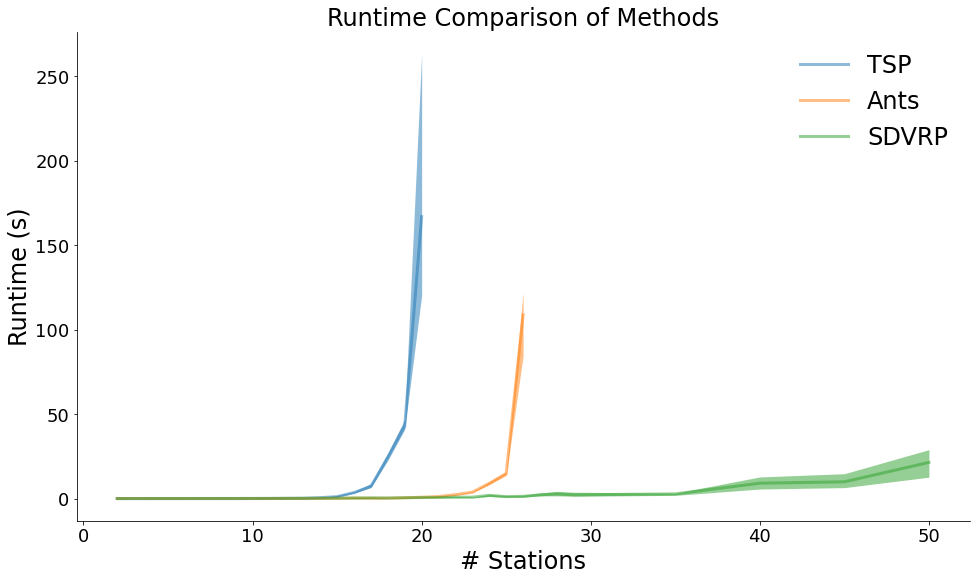

In [82]:
fig, ax = plt.subplots(figsize=(16, 9))

results = {'TSP':   (  tsp_n_stations,   tsp_time_taken), 
           'Ants':  ( ants_n_stations,  ants_time_taken),
           'SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, alpha=0.5, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

#ax.set_yscale('log')

ax.legend(frameon=False)

sns.despine()

plt.show()